In [2]:
!pip install feature-engine

In [156]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor,plot_importance,plot_metric,plot_tree,create_tree_digraph
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.metrics import r2_score
from feature_engine.encoding import MeanEncoder,CountFrequencyEncoder,DecisionTreeEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import cross_val_score,cross_val_predict,KFold,GridSearchCV
import joblib
from sklearn.pipeline import Pipeline

In [157]:
data=pd.read_csv("data_cleaned.csv")
df=data.copy()
df.head()

,price,const_type,net_m2,brut_m2,room,age,floor,no_of_floor,heating,due,deposit,no_of_bathroom,no_of_wc,in_site,furniture,location
0,1900,Betonarme,50,70,1+1,5-10,13,16,Merkezi (Pay Ölçer),0,0,1,1,Hayır,Boş,Avcılar
1,4000,Betonarme,115,125,3+1,20 Ve Üzeri,4,5,Merkezi Doğalgaz,450,4000,1,1,Hayır,Boş,Beşiktaş
2,2200,Betonarme,100,120,3+1,1-4,0,6,Kombi Doğalgaz,50,4400,1,1,Hayır,Eşyalı,Beylikdüzü
3,2000,Betonarme,90,100,2+1,5-10,1,9,Merkezi (Pay Ölçer),280,0,1,1,Hayır,Eşyalı,Esenyurt
4,1500,Betonarme,85,98,2+1,5-10,3,5,Kombi Doğalgaz,40,1500,1,1,Hayır,Boş,Pendik


In [158]:

df=df.drop(["brut_m2","floor","const_type"],axis=1)

In [159]:
df.shape

(1290, 13)

## Cross Validation

In [160]:
cv = KFold(n_splits=5, random_state=0, shuffle=True) 
X=df.drop(["price"],axis=1)
y=df["price"]
model=LGBMRegressor(random_state=23)
my_scores=[]
for train_index, test_index in cv.split(X): 

    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], y.loc[train_index], y.loc[test_index] 
    encoder=CountFrequencyEncoder(variables=["location"])
    X_train_enc=encoder.fit_transform(X_train,y_train)
    X_test_enc=encoder.transform(X_test)

    encoder=MeanEncoder(variables=["room","age","heating"])
    X_train_enc=encoder.fit_transform(X_train_enc,y_train)
    X_test_enc=encoder.transform(X_test_enc)

    encoder=OneHotEncoder(variables=["furniture","in_site"],drop_last=True)
    X_train_enc=encoder.fit_transform(X_train_enc,y_train)
    X_test_enc=encoder.transform(X_test_enc)

    scaler=MinMaxScaler()
    X_train_scaled=scaler.fit_transform(X_train_enc)
    X_test_scaled=scaler.transform(X_test_enc)

    model.fit(X_train_scaled, y_train) 
    my_scores.append(model.score(X_test_scaled, y_test)) 
print("-"*5+str(model)+"-"*5)
print("The mean value is:",np.mean(my_scores) ) 
print("scores:",my_scores)
print(" ") 


-----LGBMRegressor(random_state=23)-----
The mean value is: 0.6699118532666564
scores: [0.6766495917632505, 0.7013162797200885, 0.6249158082976434, 0.7251687402685794, 0.6215088462837204]
 


In [169]:
X=df.drop(["price"],axis=1)
y=df["price"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((903, 12), (387, 12), (903,), (387,))

In [170]:
encoder=CountFrequencyEncoder(variables=["location"])
X_train_enc=encoder.fit_transform(X_train)
X_test_enc=encoder.transform(X_test)

In [172]:
encoder=MeanEncoder(variables=["room","age","heating"])
X_train_enc=encoder.fit_transform(X_train_enc,y_train)
X_test_enc=encoder.transform(X_test_enc)

In [173]:
encoder=OneHotEncoder(variables=["furniture","in_site"],drop_last=True)
X_train_enc=encoder.fit_transform(X_train_enc)
X_test_enc=encoder.transform(X_test_enc)

In [174]:
X_train_enc.shape,X_test_enc.shape

((903, 12), (387, 12))

In [175]:
X_train_enc.head()

,net_m2,room,age,no_of_floor,heating,due,deposit,no_of_bathroom,no_of_wc,location,furniture_Boş,in_site_Hayır
261,95,2475.760204,2454.430380,9,2845.024876,100,2800,2,1,33,1,1
772,55,2484.000000,2198.677249,20,2845.024876,400,0,1,1,60,1,1
1017,60,2163.973799,2487.942857,4,1962.607261,0,1200,1,1,37,1,1
2,100,2475.760204,2487.942857,6,1962.607261,50,4400,1,1,24,0,1
422,90,2012.867647,1846.842105,4,1962.607261,0,0,2,1,37,1,1


In [176]:
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train_enc)
X_test_scaled=scaler.transform(X_test_enc)

In [177]:
model=LGBMRegressor(max_depth=3,reg_alpha=20,reg_lambda=65)
model.fit(X_train_scaled,y_train)
pred=model.predict(X_test_scaled)
print("Train R2 :",model.score(X_train_scaled,y_train))
print("Test R2 :",model.score(X_test_scaled,y_test))
print("MSE :",mean_squared_error(y_test,pred))
print("RMSE :",np.sqrt(mean_squared_error(y_test,pred)))
print("MAE :",mean_absolute_error(y_test,pred))
#overfitting

Train R2 : 0.6467081737179864
Test R2 : 0.6030080819274709
MSE : 449543.6702797503
RMSE : 670.4801788865576
MAE : 483.3361509954205


In [178]:
pd.DataFrame({"test":y_test,"pred":pred}).head(10)

,test,pred
661,2800,2842.557074
472,2500,1890.821190
328,2000,1872.376162
240,1900,1954.624004
349,2300,2061.727109
312,2200,2798.221954
794,1600,1854.885237
937,1750,1947.618695
1011,3000,2534.606855
211,1600,1789.242869


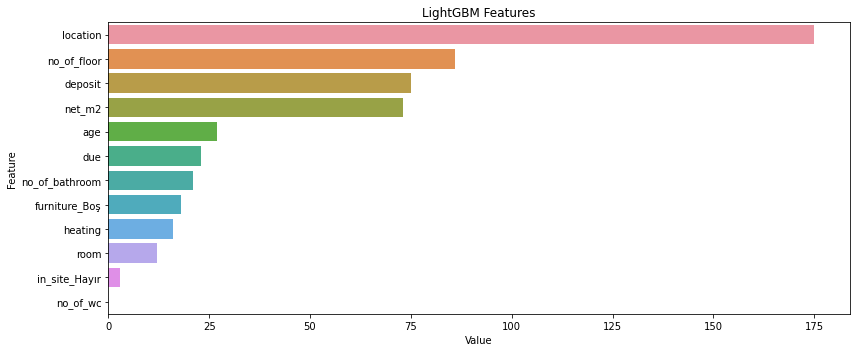

In [179]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train_enc.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [180]:
#plot_tree(model)

### Pipeline

In [181]:
pipe=Pipeline([
        ("CountFrequencyEncoder",CountFrequencyEncoder(variables=["location"])),
        ("MeanEncoder",MeanEncoder(variables=["room","age","heating"])),
        ("OneHotEncoder",OneHotEncoder(variables=["furniture","in_site"])),
        ("MinMaxScaler",MinMaxScaler()),
        ("LGBM",LGBMRegressor(max_depth=3,reg_alpha=0.5,reg_lambda=50,random_state=0))
])

In [182]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('CountFrequencyEncoder',
                 CountFrequencyEncoder(variables=['location'])),
                ('MeanEncoder',
                 MeanEncoder(variables=['room', 'age', 'heating'])),
                ('OneHotEncoder',
                 OneHotEncoder(variables=['furniture', 'in_site'])),
                ('MinMaxScaler', MinMaxScaler()),
                ('LGBM',
                 LGBMRegressor(max_depth=3, random_state=0, reg_alpha=0.5,
                               reg_lambda=50))])

In [183]:
pred=pipe.predict(X_test)

In [184]:
pipe.score(X_train,y_train),pipe.score(X_test,y_test)

(0.6574446956690744, 0.6060611136384553)

In [185]:
joblib.dump(pipe,'first_pipeline.pkl')


['first_pipeline.pkl']

In [186]:
pipe=joblib.load("first_pipeline.pkl")
pipe

Pipeline(steps=[('CountFrequencyEncoder',
                 CountFrequencyEncoder(variables=['location'])),
                ('MeanEncoder',
                 MeanEncoder(variables=['room', 'age', 'heating'])),
                ('OneHotEncoder',
                 OneHotEncoder(variables=['furniture', 'in_site'])),
                ('MinMaxScaler', MinMaxScaler()),
                ('LGBM',
                 LGBMRegressor(max_depth=3, random_state=0, reg_alpha=0.5,
                               reg_lambda=50))])

In [187]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('CountFrequencyEncoder',
                 CountFrequencyEncoder(variables=['location'])),
                ('MeanEncoder',
                 MeanEncoder(variables=['room', 'age', 'heating'])),
                ('OneHotEncoder',
                 OneHotEncoder(variables=['furniture', 'in_site'])),
                ('MinMaxScaler', MinMaxScaler()),
                ('LGBM',
                 LGBMRegressor(max_depth=3, random_state=0, reg_alpha=0.5,
                               reg_lambda=50))])

In [188]:
pipe.score(X_test,y_test)

0.6060611136384553